In [ ]:
# Importing libraries:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torchvision.utils import make_grid

In [ ]:
# Defining transforms for training and testing data:
transform = transforms.Compose(
		[transforms.RandomCrop(32, padding=4),
		 transforms.RandomHorizontalFlip(),
		 transforms.ToTensor(),
		 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# Downloading training and testing data:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Initializing batch size:
batch=32

In [ ]:
# Creating training and testing dataloaders:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-6-cd044a00fe26>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stdDev = torch.tensor(means).reshape(1,3,1,1)


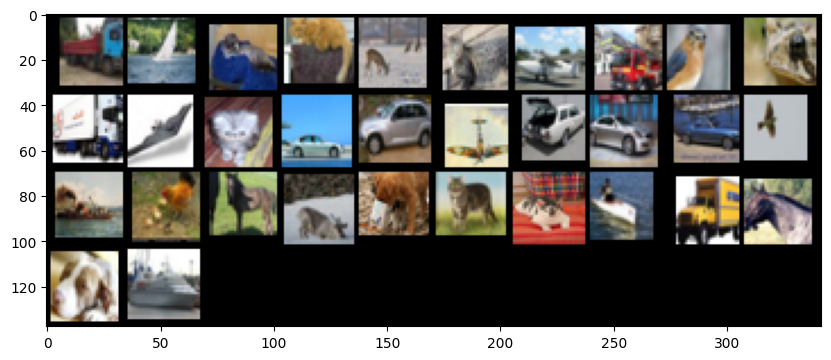

In [ ]:
#visualizing training data

data_stats = [(0.5,0.5,0.5),(0.5,0.5,0.5)]

def denormalize(images,means,stdDev):
    means = torch.tensor(means).reshape(1,3,1,1)
    stdDev = torch.tensor(means).reshape(1,3,1,1)
    return(images*stdDev+means)

def showPreview(dl):

    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
        break

showPreview(train_loader)

In [ ]:
# Getting class names from the dataset:
classes = trainset.class_to_idx

In [ ]:
# Defining basic block:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1,dropout =0.2):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(p = dropout)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# Defining Resnet architecture:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,dropout =0.2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Creating lists for train and test loss and accuracies:
train_losses = []
train_acc = []
test_losses_l1 = []
test_acc_l1 = []

In [ ]:
# Function train:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

In [ ]:
# Function test:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion= nn.CrossEntropyLoss().to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [ ]:
# Geting cpu or gpu device for training:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
model = ResNet(BasicBlock, [2,3,2,2]).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [ ]:
# Displaying number of trainable parameters:
sum(p.numel() for p in model.parameters() if p.requires_grad)

4479946

In [ ]:
# Displaying summary of the model:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
           Dropout-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
# Initializing batch size Learning Rate annd moment:
epochs =65
LR = 0.01
moment = 0.9

In [ ]:
# Training the model over training and testing datasets:

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=moment)
scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=epochs)

for epoch in range(epochs):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1761: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 Learning_Rate [0.0040000000000000036]


Loss=1.347741723060608 Batch_id=1562 Accuracy=42.08: 100%|██████████| 1563/1563 [00:56<00:00, 27.50it/s]



Test set: Average loss: 0.0401, Accuracy: 5335/10000 (53.3500%)

Epoch: 1 Learning_Rate [0.004690436303309994]


Loss=0.9153853058815002 Batch_id=1562 Accuracy=60.10: 100%|██████████| 1563/1563 [00:53<00:00, 29.37it/s]



Test set: Average loss: 0.0297, Accuracy: 6624/10000 (66.2400%)

Epoch: 2 Learning_Rate [0.006741882617867956]


Loss=0.6525059342384338 Batch_id=1562 Accuracy=68.06: 100%|██████████| 1563/1563 [00:54<00:00, 28.77it/s]



Test set: Average loss: 0.0263, Accuracy: 7079/10000 (70.7900%)

Epoch: 3 Learning_Rate [0.010095322568262968]


Loss=0.48516109585762024 Batch_id=1562 Accuracy=72.68: 100%|██████████| 1563/1563 [00:53<00:00, 29.48it/s]



Test set: Average loss: 0.0217, Accuracy: 7566/10000 (75.6600%)

Epoch: 4 Learning_Rate [0.014654283792714912]


Loss=0.45331141352653503 Batch_id=1562 Accuracy=75.82: 100%|██████████| 1563/1563 [00:53<00:00, 29.44it/s]



Test set: Average loss: 0.0196, Accuracy: 7810/10000 (78.1000%)

Epoch: 5 Learning_Rate [0.0202876132772761]


Loss=0.6066457033157349 Batch_id=1562 Accuracy=78.36: 100%|██████████| 1563/1563 [00:53<00:00, 29.20it/s]



Test set: Average loss: 0.0168, Accuracy: 8147/10000 (81.4700%)

Epoch: 6 Learning_Rate [0.026833250389252883]


Loss=1.033954381942749 Batch_id=1562 Accuracy=80.12: 100%|██████████| 1563/1563 [00:53<00:00, 28.98it/s]



Test set: Average loss: 0.0187, Accuracy: 7911/10000 (79.1100%)

Epoch: 7 Learning_Rate [0.03410288906654518]


Loss=0.47213131189346313 Batch_id=1562 Accuracy=82.00: 100%|██████████| 1563/1563 [00:52<00:00, 29.66it/s]



Test set: Average loss: 0.0168, Accuracy: 8177/10000 (81.7700%)

Epoch: 8 Learning_Rate [0.041887395040205146]


Loss=0.6845409870147705 Batch_id=1562 Accuracy=83.30: 100%|██████████| 1563/1563 [00:53<00:00, 29.12it/s]



Test set: Average loss: 0.0151, Accuracy: 8385/10000 (83.8500%)

Epoch: 9 Learning_Rate [0.04996282224658489]


Loss=0.5836699604988098 Batch_id=1562 Accuracy=84.28: 100%|██████████| 1563/1563 [00:54<00:00, 28.93it/s]



Test set: Average loss: 0.0143, Accuracy: 8445/10000 (84.4500%)

Epoch: 10 Learning_Rate [0.05809685534785018]


Loss=0.22033265233039856 Batch_id=1562 Accuracy=85.52: 100%|██████████| 1563/1563 [00:53<00:00, 29.39it/s]



Test set: Average loss: 0.0127, Accuracy: 8621/10000 (86.2100%)

Epoch: 11 Learning_Rate [0.06605549302127442]


Loss=0.4270288050174713 Batch_id=1562 Accuracy=86.38: 100%|██████████| 1563/1563 [00:54<00:00, 28.75it/s]



Test set: Average loss: 0.0137, Accuracy: 8489/10000 (84.8900%)

Epoch: 12 Learning_Rate [0.07360977975124833]


Loss=0.34652554988861084 Batch_id=1562 Accuracy=87.22: 100%|██████████| 1563/1563 [00:53<00:00, 29.37it/s]



Test set: Average loss: 0.0122, Accuracy: 8660/10000 (86.6000%)

Epoch: 13 Learning_Rate [0.08054239246260576]


Loss=0.18084831535816193 Batch_id=1562 Accuracy=87.87: 100%|██████████| 1563/1563 [00:53<00:00, 29.44it/s]



Test set: Average loss: 0.0120, Accuracy: 8719/10000 (87.1900%)

Epoch: 14 Learning_Rate [0.08665389250981717]


Loss=0.35858097672462463 Batch_id=1562 Accuracy=88.42: 100%|██████████| 1563/1563 [00:53<00:00, 29.36it/s]



Test set: Average loss: 0.0117, Accuracy: 8735/10000 (87.3500%)

Epoch: 15 Learning_Rate [0.09176846316370442]


Loss=0.20981067419052124 Batch_id=1562 Accuracy=89.23: 100%|██████████| 1563/1563 [00:54<00:00, 28.83it/s]



Test set: Average loss: 0.0119, Accuracy: 8741/10000 (87.4100%)

Epoch: 16 Learning_Rate [0.09573896753863052]


Loss=0.16630728542804718 Batch_id=1562 Accuracy=89.62: 100%|██████████| 1563/1563 [00:53<00:00, 29.42it/s]



Test set: Average loss: 0.0109, Accuracy: 8848/10000 (88.4800%)

Epoch: 17 Learning_Rate [0.09845118145280796]


Loss=0.9488949179649353 Batch_id=1562 Accuracy=90.31: 100%|██████████| 1563/1563 [00:53<00:00, 29.07it/s]



Test set: Average loss: 0.0115, Accuracy: 8780/10000 (87.8000%)

Epoch: 18 Learning_Rate [0.09982707945004128]


Loss=0.08780954778194427 Batch_id=1562 Accuracy=90.77: 100%|██████████| 1563/1563 [00:53<00:00, 29.45it/s]



Test set: Average loss: 0.0103, Accuracy: 8925/10000 (89.2500%)

Epoch: 19 Learning_Rate [0.09997020714672541]


Loss=0.07756831496953964 Batch_id=1562 Accuracy=91.25: 100%|██████████| 1563/1563 [00:53<00:00, 29.32it/s]



Test set: Average loss: 0.0111, Accuracy: 8859/10000 (88.5900%)

Epoch: 20 Learning_Rate [0.0997320773064547]


Loss=0.21421733498573303 Batch_id=1562 Accuracy=91.82: 100%|██████████| 1563/1563 [00:54<00:00, 28.79it/s]



Test set: Average loss: 0.0106, Accuracy: 8859/10000 (88.5900%)

Epoch: 21 Learning_Rate [0.09925695242304589]


Loss=0.24901264905929565 Batch_id=1562 Accuracy=92.03: 100%|██████████| 1563/1563 [00:53<00:00, 29.35it/s]



Test set: Average loss: 0.0100, Accuracy: 8970/10000 (89.7000%)

Epoch: 22 Learning_Rate [0.09854709668293912]


Loss=0.05945767089724541 Batch_id=1562 Accuracy=92.51: 100%|██████████| 1563/1563 [00:57<00:00, 27.09it/s]



Test set: Average loss: 0.0091, Accuracy: 9035/10000 (90.3500%)

Epoch: 23 Learning_Rate [0.09760589287200253]


Loss=1.0615291595458984 Batch_id=1562 Accuracy=92.83: 100%|██████████| 1563/1563 [00:53<00:00, 29.37it/s]



Test set: Average loss: 0.0100, Accuracy: 8967/10000 (89.6700%)

Epoch: 24 Learning_Rate [0.0964378262550171]


Loss=0.33807170391082764 Batch_id=1562 Accuracy=93.07: 100%|██████████| 1563/1563 [00:54<00:00, 28.70it/s]



Test set: Average loss: 0.0099, Accuracy: 8958/10000 (89.5800%)

Epoch: 25 Learning_Rate [0.09504846320134738]


Loss=0.23256902396678925 Batch_id=1562 Accuracy=93.38: 100%|██████████| 1563/1563 [00:55<00:00, 28.34it/s]



Test set: Average loss: 0.0097, Accuracy: 8995/10000 (89.9500%)

Epoch: 26 Learning_Rate [0.09344442465865659]


Loss=0.02280174382030964 Batch_id=1562 Accuracy=93.57: 100%|██████████| 1563/1563 [00:55<00:00, 27.91it/s]



Test set: Average loss: 0.0097, Accuracy: 9000/10000 (90.0000%)

Epoch: 27 Learning_Rate [0.09163335460107579]


Loss=0.24533161520957947 Batch_id=1562 Accuracy=94.02: 100%|██████████| 1563/1563 [00:54<00:00, 28.91it/s]



Test set: Average loss: 0.0103, Accuracy: 8974/10000 (89.7400%)

Epoch: 28 Learning_Rate [0.08962388360218614]


Loss=0.13994139432907104 Batch_id=1562 Accuracy=94.15: 100%|██████████| 1563/1563 [00:53<00:00, 28.96it/s]



Test set: Average loss: 0.0090, Accuracy: 9105/10000 (91.0500%)

Epoch: 29 Learning_Rate [0.08742558770640542]


Loss=0.14222870767116547 Batch_id=1562 Accuracy=94.53: 100%|██████████| 1563/1563 [00:54<00:00, 28.66it/s]



Test set: Average loss: 0.0090, Accuracy: 9098/10000 (90.9800%)

Epoch: 30 Learning_Rate [0.08504894279477551]


Loss=0.006893951445817947 Batch_id=1562 Accuracy=94.85: 100%|██████████| 1563/1563 [00:54<00:00, 28.79it/s]



Test set: Average loss: 0.0089, Accuracy: 9116/10000 (91.1600%)

Epoch: 31 Learning_Rate [0.08250527466261848]


Loss=0.3205088675022125 Batch_id=1562 Accuracy=95.00: 100%|██████████| 1563/1563 [00:54<00:00, 28.86it/s]



Test set: Average loss: 0.0092, Accuracy: 9076/10000 (90.7600%)

Epoch: 32 Learning_Rate [0.07980670504696417]


Loss=0.012809062376618385 Batch_id=1562 Accuracy=94.84: 100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]



Test set: Average loss: 0.0090, Accuracy: 9113/10000 (91.1300%)

Epoch: 33 Learning_Rate [0.07696609386095307]


Loss=0.01638658717274666 Batch_id=1562 Accuracy=95.39: 100%|██████████| 1563/1563 [00:53<00:00, 29.02it/s]



Test set: Average loss: 0.0092, Accuracy: 9131/10000 (91.3100%)

Epoch: 34 Learning_Rate [0.07399697791049374]


Loss=0.2670666575431824 Batch_id=1562 Accuracy=95.64: 100%|██████████| 1563/1563 [00:55<00:00, 28.24it/s]



Test set: Average loss: 0.0093, Accuracy: 9095/10000 (90.9500%)

Epoch: 35 Learning_Rate [0.07091350638521811]


Loss=0.030836664140224457 Batch_id=1562 Accuracy=95.80: 100%|██████████| 1563/1563 [00:54<00:00, 28.88it/s]



Test set: Average loss: 0.0089, Accuracy: 9137/10000 (91.3700%)

Epoch: 36 Learning_Rate [0.06773037343114938]


Loss=0.26475611329078674 Batch_id=1562 Accuracy=95.95: 100%|██████████| 1563/1563 [00:53<00:00, 29.08it/s]



Test set: Average loss: 0.0088, Accuracy: 9137/10000 (91.3700%)

Epoch: 37 Learning_Rate [0.06446274812640448]


Loss=0.1961265653371811 Batch_id=1562 Accuracy=96.19: 100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]



Test set: Average loss: 0.0095, Accuracy: 9138/10000 (91.3800%)

Epoch: 38 Learning_Rate [0.06112620219362893]


Loss=0.13210102915763855 Batch_id=1562 Accuracy=96.36: 100%|██████████| 1563/1563 [00:55<00:00, 28.29it/s]



Test set: Average loss: 0.0089, Accuracy: 9169/10000 (91.6900%)

Epoch: 39 Learning_Rate [0.0577366357936471]


Loss=0.17974545061588287 Batch_id=1562 Accuracy=96.69: 100%|██████████| 1563/1563 [00:54<00:00, 28.84it/s]



Test set: Average loss: 0.0087, Accuracy: 9185/10000 (91.8500%)

Epoch: 40 Learning_Rate [0.054310201753955]


Loss=0.03694014623761177 Batch_id=1562 Accuracy=96.87: 100%|██████████| 1563/1563 [00:54<00:00, 28.84it/s]



Test set: Average loss: 0.0092, Accuracy: 9157/10000 (91.5700%)

Epoch: 41 Learning_Rate [0.05086322859314125]


Loss=0.00404582591727376 Batch_id=1562 Accuracy=96.95: 100%|██████████| 1563/1563 [00:54<00:00, 28.60it/s]



Test set: Average loss: 0.0089, Accuracy: 9220/10000 (92.2000%)

Epoch: 42 Learning_Rate [0.0474121427080601]


Loss=0.349939227104187 Batch_id=1562 Accuracy=97.07: 100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]



Test set: Average loss: 0.0088, Accuracy: 9181/10000 (91.8100%)

Epoch: 43 Learning_Rate [0.04397339009456991]


Loss=0.14790970087051392 Batch_id=1562 Accuracy=97.22: 100%|██████████| 1563/1563 [00:55<00:00, 28.18it/s]



Test set: Average loss: 0.0092, Accuracy: 9185/10000 (91.8500%)

Epoch: 44 Learning_Rate [0.04056335797487326]


Loss=0.022979049012064934 Batch_id=1562 Accuracy=97.40: 100%|██████████| 1563/1563 [00:54<00:00, 28.77it/s]



Test set: Average loss: 0.0092, Accuracy: 9180/10000 (91.8000%)

Epoch: 45 Learning_Rate [0.03719829670494066]


Loss=0.0151370232924819 Batch_id=1562 Accuracy=97.68: 100%|██████████| 1563/1563 [00:54<00:00, 28.84it/s]



Test set: Average loss: 0.0096, Accuracy: 9193/10000 (91.9300%)

Epoch: 46 Learning_Rate [0.03389424233416384]


Loss=0.006508706137537956 Batch_id=1562 Accuracy=97.60: 100%|██████████| 1563/1563 [00:54<00:00, 28.74it/s]



Test set: Average loss: 0.0090, Accuracy: 9189/10000 (91.8900%)

Epoch: 47 Learning_Rate [0.030666940186277653]


Loss=0.15573392808437347 Batch_id=1562 Accuracy=97.92: 100%|██████████| 1563/1563 [00:55<00:00, 28.31it/s]



Test set: Average loss: 0.0090, Accuracy: 9228/10000 (92.2800%)

Epoch: 48 Learning_Rate [0.02753176982572212]


Loss=0.0057310257107019424 Batch_id=1562 Accuracy=98.15: 100%|██████████| 1563/1563 [00:56<00:00, 27.84it/s]



Test set: Average loss: 0.0091, Accuracy: 9230/10000 (92.3000%)

Epoch: 49 Learning_Rate [0.0245036717670141]


Loss=0.026744775474071503 Batch_id=1562 Accuracy=98.24: 100%|██████████| 1563/1563 [00:55<00:00, 28.34it/s]



Test set: Average loss: 0.0089, Accuracy: 9242/10000 (92.4200%)

Epoch: 50 Learning_Rate [0.021597076276391566]


Loss=0.01089424453675747 Batch_id=1562 Accuracy=98.30: 100%|██████████| 1563/1563 [00:54<00:00, 28.52it/s]



Test set: Average loss: 0.0091, Accuracy: 9259/10000 (92.5900%)

Epoch: 51 Learning_Rate [0.0188258346050237]


Loss=0.012989388778805733 Batch_id=1562 Accuracy=98.48: 100%|██████████| 1563/1563 [01:00<00:00, 25.72it/s]



Test set: Average loss: 0.0090, Accuracy: 9309/10000 (93.0900%)

Epoch: 52 Learning_Rate [0.016203152981491113]


Loss=0.0030278994236141443 Batch_id=1562 Accuracy=98.69: 100%|██████████| 1563/1563 [00:56<00:00, 27.81it/s]



Test set: Average loss: 0.0090, Accuracy: 9288/10000 (92.8800%)

Epoch: 53 Learning_Rate [0.013741529678092617]


Loss=0.22174300253391266 Batch_id=1562 Accuracy=98.84: 100%|██████████| 1563/1563 [00:56<00:00, 27.79it/s]



Test set: Average loss: 0.0090, Accuracy: 9279/10000 (92.7900%)

Epoch: 54 Learning_Rate [0.011452695450885978]


Loss=0.012256343849003315 Batch_id=1562 Accuracy=99.00: 100%|██████████| 1563/1563 [00:55<00:00, 28.20it/s]



Test set: Average loss: 0.0092, Accuracy: 9302/10000 (93.0200%)

Epoch: 55 Learning_Rate [0.009347557637293264]


Loss=0.016623282805085182 Batch_id=1562 Accuracy=98.96: 100%|██████████| 1563/1563 [00:55<00:00, 28.40it/s]



Test set: Average loss: 0.0091, Accuracy: 9312/10000 (93.1200%)

Epoch: 56 Learning_Rate [0.007436148177670761]


Loss=0.01836417242884636 Batch_id=1562 Accuracy=99.15: 100%|██████████| 1563/1563 [00:54<00:00, 28.60it/s]



Test set: Average loss: 0.0087, Accuracy: 9330/10000 (93.3000%)

Epoch: 57 Learning_Rate [0.005727575808544641]


Loss=0.007704332936555147 Batch_id=1562 Accuracy=99.20: 100%|██████████| 1563/1563 [00:55<00:00, 28.12it/s]



Test set: Average loss: 0.0089, Accuracy: 9342/10000 (93.4200%)

Epoch: 58 Learning_Rate [0.00422998265533339]


Loss=0.08234421163797379 Batch_id=1562 Accuracy=99.33: 100%|██████████| 1563/1563 [00:55<00:00, 28.34it/s]



Test set: Average loss: 0.0090, Accuracy: 9339/10000 (93.3900%)

Epoch: 59 Learning_Rate [0.0029505054314122557]


Loss=0.03305169194936752 Batch_id=1562 Accuracy=99.38: 100%|██████████| 1563/1563 [00:55<00:00, 28.15it/s]



Test set: Average loss: 0.0091, Accuracy: 9349/10000 (93.4900%)

Epoch: 60 Learning_Rate [0.0018952414284239454]


Loss=0.03516634553670883 Batch_id=1562 Accuracy=99.36: 100%|██████████| 1563/1563 [00:55<00:00, 28.37it/s]



Test set: Average loss: 0.0089, Accuracy: 9346/10000 (93.4600%)

Epoch: 61 Learning_Rate [0.0010692194599072938]


Loss=0.015535186976194382 Batch_id=1562 Accuracy=99.38: 100%|██████████| 1563/1563 [00:54<00:00, 28.66it/s]



Test set: Average loss: 0.0089, Accuracy: 9357/10000 (93.5700%)

Epoch: 62 Learning_Rate [0.00047637589671063827]


Loss=0.0003867058549076319 Batch_id=1562 Accuracy=99.42: 100%|██████████| 1563/1563 [00:55<00:00, 28.22it/s]



Test set: Average loss: 0.0092, Accuracy: 9356/10000 (93.5600%)

Epoch: 63 Learning_Rate [0.00011953590839208394]


Loss=0.0006322357221506536 Batch_id=1562 Accuracy=99.42: 100%|██████████| 1563/1563 [00:54<00:00, 28.47it/s]



Test set: Average loss: 0.0087, Accuracy: 9307/10000 (93.0700%)

Epoch: 64 Learning_Rate [4e-07]


Loss=0.008422978222370148 Batch_id=1562 Accuracy=99.41: 100%|██████████| 1563/1563 [00:54<00:00, 28.65it/s]



Test set: Average loss: 0.0093, Accuracy: 9331/10000 (93.3100%)



In [ ]:
#converting from cuda tensors to .cpu()

arr_train=np.array(torch.Tensor(train_losses).cpu())

arr_test=np.array(torch.Tensor(test_losses_l1).cpu())

arr_train_acc=np.array(torch.Tensor(train_acc).cpu())

arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())

In [ ]:
# Getting the train loss for the last batch for every epoch:
arr_train1 =[]
for i in range(len(arr_train)):
  if (i%1563) == 0:
    arr_train1.append(arr_train[i])

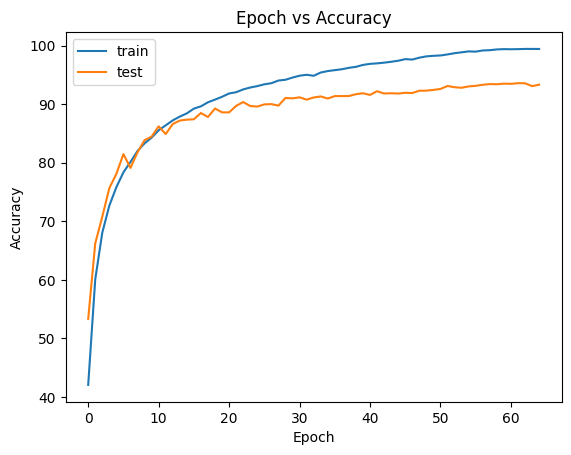

In [ ]:
# Plotting the accuracy:
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

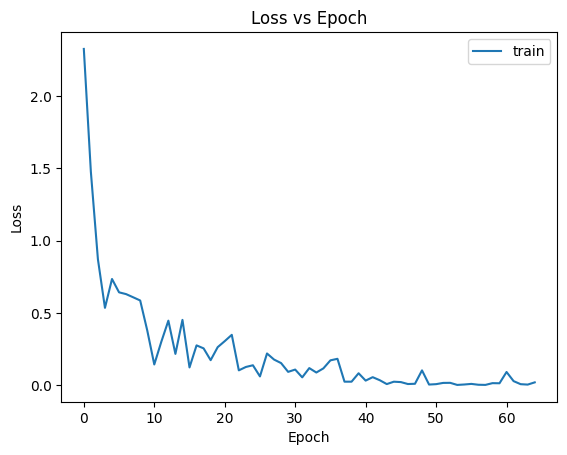

In [ ]:
# Printing train  and test loss:
plt.plot(arr_train1 )
plt.legend(["train"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

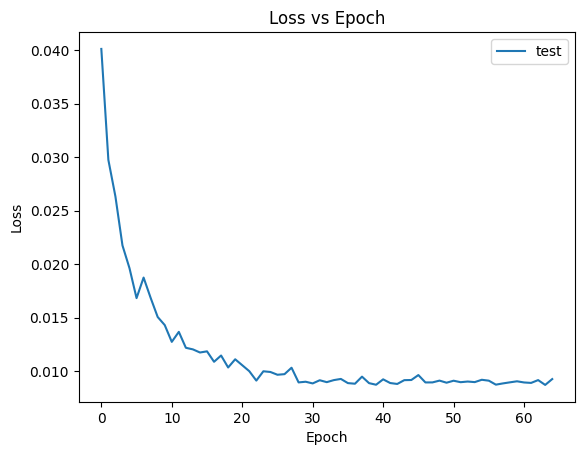

In [ ]:

plt.plot(arr_test)
plt.legend(["test"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Save random initial weights:
torch.save(model.state_dict(), 'Model.pt')

model.cpu()
model_scripted = torch.jit.script(model)
# model_scripted.save('ResNet_sgd_cifar10.pt')
print("Saved Model")

Saved Model


In [ ]:
model = torch.jit.load("/content/ResNetSGD.pt")

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
no_label_data = unpickle("/content/cifar_test_nolabels.pkl")
for i in no_label_data.keys():
  custom_test = no_label_data[i]
  break

# custom_test = torch.from_numpy(custom_test)
custom_test

array([[133, 136, 136, ..., 226, 225, 224],
       [160, 177, 176, ...,  89,  89,  88],
       [255, 255, 255, ..., 211, 213, 215],
       ...,
       [ 29,  29,  45, ..., 156, 155, 154],
       [124, 123, 126, ...,  49,  49,  51],
       [255, 255, 255, ..., 250, 251, 255]], dtype=uint8)

In [ ]:
# Reshape the data to the correct format (num_images, 3, 32, 32)
reshaped_data = custom_test.reshape((-1, 3, 32, 32)).astype(np.float32)

# Convert the first image to a PyTorch tensor and add a batch dimension
# Assuming pixel values are expected to be in the range [0, 1] for the model
unlabeled_test = torch.tensor(reshaped_data/ 255).unsqueeze(0)

unlabeled_test

tensor([[[[[0.5216, 0.5333, 0.5333,  ..., 0.4863, 0.4745, 0.4627],
           [0.5098, 0.5098, 0.5176,  ..., 0.4902, 0.4431, 0.4510],
           [0.5216, 0.5216, 0.5176,  ..., 0.5373, 0.4980, 0.4706],
           ...,
           [0.2980, 0.2941, 0.3137,  ..., 0.1569, 0.1725, 0.1647],
           [0.7255, 0.7216, 0.7137,  ..., 0.6314, 0.6275, 0.6392],
           [0.8588, 0.8353, 0.8392,  ..., 0.8863, 0.8824, 0.8784]],

          [[0.5216, 0.5333, 0.5333,  ..., 0.4863, 0.4745, 0.4627],
           [0.5098, 0.5098, 0.5176,  ..., 0.4902, 0.4431, 0.4510],
           [0.5216, 0.5216, 0.5176,  ..., 0.5373, 0.4980, 0.4706],
           ...,
           [0.2980, 0.2941, 0.3137,  ..., 0.1569, 0.1725, 0.1647],
           [0.7255, 0.7216, 0.7137,  ..., 0.6314, 0.6275, 0.6392],
           [0.8588, 0.8353, 0.8392,  ..., 0.8863, 0.8824, 0.8784]],

          [[0.5216, 0.5333, 0.5333,  ..., 0.4863, 0.4745, 0.4627],
           [0.5098, 0.5098, 0.5176,  ..., 0.4902, 0.4431, 0.4510],
           [0.5216, 0.5216

In [ ]:
from torch.utils.data import Dataset

class CIFARCustomDataset(Dataset):
    """Custom Dataset for loading CIFAR images on-the-fly."""

    def __init__(self, data):
        """
        Args:
            data (numpy.ndarray): The array containing CIFAR image data.
        """
        self.data = data

    def __len__(self):
        """Denotes the total number of samples."""
        return len(self.data)

    def __getitem__(self, index):
        """Generates one sample of data."""
        # Load data and get label
        x = self.data[index]
        # Reshape and normalize the image data
        x = x.reshape(3, 32, 32).astype(np.float32) / 255
        return torch.tensor(x)

# Create an instance of our custom dataset
custom_dataset = CIFARCustomDataset(data=reshaped_data)

# Create the DataLoader using the custom dataset
dataloader_custom = DataLoader(custom_dataset, batch_size=64, shuffle=False)

# Show an example of getting a batch from the custom dataloader
for images in dataloader_custom:
    print(f"Batch shape: {images.shape}")
    break  # We only want to show the shape of the first batch as an example


Batch shape: torch.Size([64, 3, 32, 32])


In [ ]:
import torch.nn.functional as F

# Assuming 'model' is your loaded model
model.eval()  # Set the model to evaluation mode

predictions = []
for images in dataloader_custom:
    images = images

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(images)
    probabilities = outputs

    # get the predicted class labels
    predicted_labels = probabilities.argmax(dim=1)

    # Store the predictions
    predictions.extend(predicted_labels.cpu().numpy())

# At this point, 'predictions' contains the predicted class labels for all images


In [ ]:
import pandas as pd

for i in no_label_data.keys():
  ids = no_label_data[i]

d = {
  "Predictions": predictions,
  "ids": ids}

final_df = pd.DataFrame.from_dict(d)
final_df.head()

,Predictions,ids
0,8,0
1,8,1
2,8,2
3,8,3
4,8,4


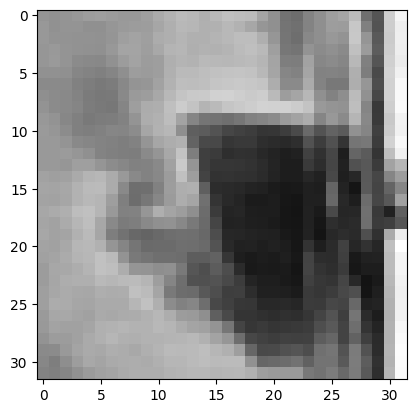

In [ ]:
import matplotlib.pyplot as plt
Image = reshaped_data[0].transpose()
Image = Image/np.amax(Image)
Image = np.clip(Image, 0, 1)
plt.imshow(Image)

In [ ]:
final_df.to_csv("")

',Predictions,ids\n0,8,0\n1,8,1\n2,8,2\n3,8,3\n4,8,4\n5,8,5\n6,8,6\n7,3,7\n8,8,8\n9,8,9\n10,8,10\n11,6,11\n12,8,12\n13,8,13\n14,8,14\n15,8,15\n16,8,16\n17,8,17\n18,8,18\n19,8,19\n20,8,20\n21,0,21\n22,8,22\n23,8,23\n24,8,24\n25,8,25\n26,8,26\n27,8,27\n28,8,28\n29,8,29\n30,8,30\n31,8,31\n32,8,32\n33,8,33\n34,8,34\n35,8,35\n36,8,36\n37,8,37\n38,8,38\n39,8,39\n40,8,40\n41,8,41\n42,8,42\n43,0,43\n44,8,44\n45,0,45\n46,0,46\n47,8,47\n48,8,48\n49,0,49\n50,8,50\n51,8,51\n52,8,52\n53,8,53\n54,8,54\n55,8,55\n56,8,56\n57,8,57\n58,8,58\n59,8,59\n60,8,60\n61,8,61\n62,8,62\n63,8,63\n64,8,64\n65,8,65\n66,8,66\n67,8,67\n68,8,68\n69,0,69\n70,8,70\n71,8,71\n72,8,72\n73,8,73\n74,8,74\n75,8,75\n76,8,76\n77,8,77\n78,8,78\n79,8,79\n80,8,80\n81,8,81\n82,8,82\n83,8,83\n84,8,84\n85,8,85\n86,8,86\n87,8,87\n88,8,88\n89,8,89\n90,8,90\n91,8,91\n92,8,92\n93,8,93\n94,8,94\n95,8,95\n96,8,96\n97,8,97\n98,8,98\n99,8,99\n100,8,100\n101,8,101\n102,8,102\n103,8,103\n104,8,104\n105,8,105\n106,8,106\n107,8,107\n108,8,108\n10